# Classificació d'imatges a color fent servir una xarxa preentrenada

En aquest *notebook* farem servir una arquitectura de model preentrenat per a classificar imatges de 5 categories de flors.

In [ ]:
# Començarem important les llibreries
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

##Lectura del *dataset*

Obtindrem el *dataset* d'un enllaç. Aquest *dataset* contindrà imatges en categories sota el nom "flower_fotos".

Com farem servir la funció image_dataset_from_directory de tensorflow, podríem fer servir imatges pròpies si les guardéssim adientment en l'estructura requerida de carpetes.
Per a fer-ho, caldria que ens creéssim una carpeta d'entrenament i una de validació amb el següent format:

/directori/dades/

    /clase_1

        imagen1.jpg

        imagen2.jpg

        ...

    /clase_2

        imagen1.jpg

        imagen2.jpg

        ...

    ...

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

batch_size = 256
img_height = 224
img_width = 224

228813984/228813984 [==============================] - 1s 0us/step


##Anàlisi del*dataset*

In [ ]:
# Mirem quantes imatges tenim per cada categoria
categories = os.listdir(data_dir)

# Ho guardarem en un diccionari
flower_counts = {}

# Iterem per a cada categoria
for category in categories:
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        # Contem el nombre d'imatges dins de cada categoria
        num_files = len(os.listdir(category_path))
        flower_counts[category] = num_files

# Mostrem el recompte de flors
print("Flors per categoria")
for category, count in flower_counts.items():
    print(f"{category}: {count} imatges")

Flors per categoria
tulips: 799 imatges
dandelion: 898 imatges
sunflowers: 699 imatges
daisy: 633 imatges
roses: 641 imatges


In [ ]:
# Creem el conjunt de dades d'entrenament i validació
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1234,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1234,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


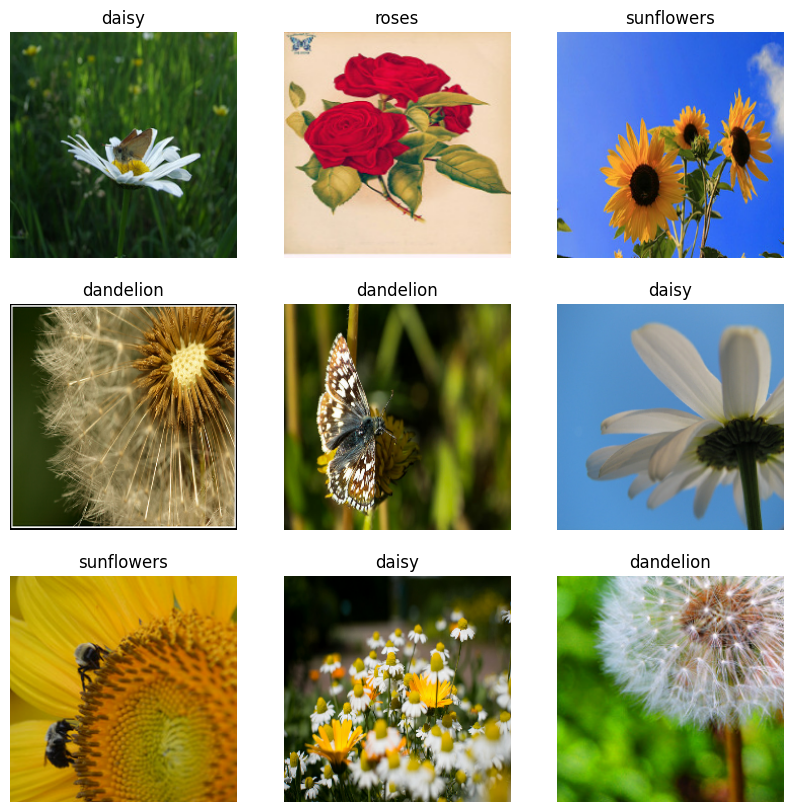

In [ ]:
#Ara visualitzarem algunes imatges a mode d'exemple.

# Definim les etiquetes de les classes.
class_names = train_ds.class_names

# Iterem sobre el conjunt de dades de validació i mostrem algunes imatges
for images, labels in val_ds.take(1):  # Agafem només el primer batch per a fer l'exemple
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Mostrem 9 imatges
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


## Carreguem el model i l'entrenem

In [ ]:
# Carreguem el model ResNet preentrenat amb 'imagenet'
base_model = ResNet50(weights='imagenet', include_top=False)


In [ ]:
# Congelem les capes base del model preentrenat
base_model.trainable = False

# Construim el model de classificació sobre el model base
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
outputs = Dense(5, activation='softmax')(x)
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
Total params: 24089477 (91.89 MB)
Trainable params: 501765 (1.91 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [9]:
# Compilem el model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenem el model
epochs = 3
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
 9/12 [=====================>........] - ETA: 2:45 - loss: 15.9419 - accuracy: 0.4596

KeyboardInterrupt: 

##Obtenció de mètriques

In [ ]:
# Avaluem el model
loss, accuracy = model.evaluate(val_ds)
print(f'Pèrdua: {loss}, Taxa d\'encert: {accuracy}')

In [ ]:
# Obtenim el nom de les etiquetes
true_labels = []
predicted_labels = []
imatges = []
for imgs, labels in val_ds:
    true_labels.extend(labels.numpy())
    imatges.extend(imgs)
    # Obtenim les prediccions en el conjunt de dades de validació
    predicted_probs = model.predict(imgs)
    predicted_labels.extend(np.argmax(predicted_probs, axis=1))

# Mostrem la matriu de confusió
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predita')
plt.ylabel('Classe original')
plt.title('Matriu de confusió')
plt.show()

In [ ]:
# Mostrem algunes imatges per veure si les prediccions han estat encertades.
plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(imatges[i].numpy().astype("uint8"))
    plt.title(f"T: {class_names[true_labels[i]]}, P: {class_names[predicted_labels[i]]}")
    plt.axis("off")
plt.show()

# Activitat

##Lectura del *dataset*

In [2]:
import tensorflow_datasets as tfds
# Començarem important les llibreries
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

In [3]:
batch_size = 256
img_height = 224
img_width = 224

In [4]:
def load_dataset():
    """
    Load stanford_dogs tensorflow dataset.
    :return:
    ds_train (tf.data.DataSet) The requested training dataset.
    ds_test (tf.data.DataSet) The requested test dataset.
    ds_info (tfds.core.DatasetInfo) The requested dataset info.
    """
    (ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                             split=['train', 'test'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True,
                                             data_dir='dogs2',
                                             batch_size=batch_size)
    return ds_train, ds_test, ds_info

In [5]:
train_ds,val_ds,ds_info = load_dataset()

##Anàlisi del*dataset*

In [6]:
class_names = ds_info.features['label'].names

In [13]:
class_names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

In [ ]:
# amb els batches no funciona, no trobo poerqué
# tfds.show_examples(train_ds,ds_info)

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

In [ ]:
ds_info.features['image'].shape

## Carreguem el model i l'entrenem

In [6]:
num_classes = ds_info.features['label'].num_classes
# shape=(None, None, 3)
shape=(img_height, img_width, 3)
# Carreguem el model ResNet preentrenat amb 'imagenet'
base_model = ResNet50(weights='imagenet', include_top=False,input_shape=shape)
base_model.trainable = False

# Construim el model de classificació sobre el model base
x = Flatten()(base_model.output)

# Congelem les capes base del model preentrenat
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(base_model.input, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [7]:
# per sortir del pas
def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224])
    return image, label

In [8]:
train_ds_preprocessed = train_ds.map(preprocess_image)
val_ds_preprocessed = val_ds.map(preprocess_image)

In [9]:
# Compilem el model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenem el model
epochs = 3
model.fit(train_ds_preprocessed, validation_data=val_ds_preprocessed, epochs=epochs)

Epoch 1/3
47/47 [==============================] - 206s 4s/step - loss: 56.5454 - accuracy: 0.0254 - val_loss: 51.7301 - val_accuracy: 0.0389
Epoch 2/3
47/47 [==============================] - 142s 3s/step - loss: 30.4768 - accuracy: 0.1229 - val_loss: 34.5180 - val_accuracy: 0.0675
Epoch 3/3
47/47 [==============================] - 140s 3s/step - loss: 20.8646 - accuracy: 0.1744 - val_loss: 33.9608 - val_accuracy: 0.0845


##Obtenció de mètriques

In [10]:
# Avaluem el model
loss, accuracy = model.evaluate(val_ds_preprocessed)
print(f'Pèrdua: {loss}, Taxa d\'encert: {accuracy}')

34/34 [==============================] - 56s 2s/step - loss: 34.1914 - accuracy: 0.0846
Pèrdua: 34.19142532348633, Taxa d'encert: 0.08461538702249527


5/5 [==============================] - 0s 85ms/step


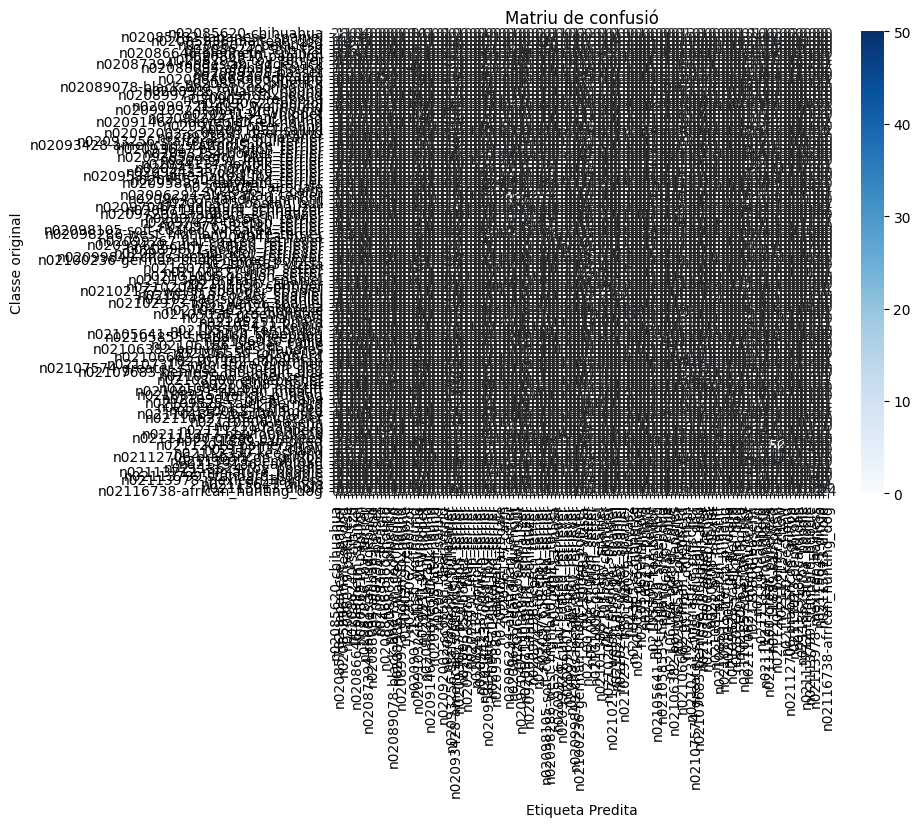

In [14]:
# Obtenim el nom de les etiquetes
true_labels = []
predicted_labels = []
imatges = []
for imgs, labels in val_ds_preprocessed:
    true_labels.extend(labels.numpy())
    imatges.extend(imgs)
    # Obtenim les prediccions en el conjunt de dades de validació
    predicted_probs = model.predict(imgs)
    predicted_labels.extend(np.argmax(predicted_probs, axis=1))

# Mostrem la matriu de confusió
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predita')
plt.ylabel('Classe original')
plt.title('Matriu de confusió')
plt.show()

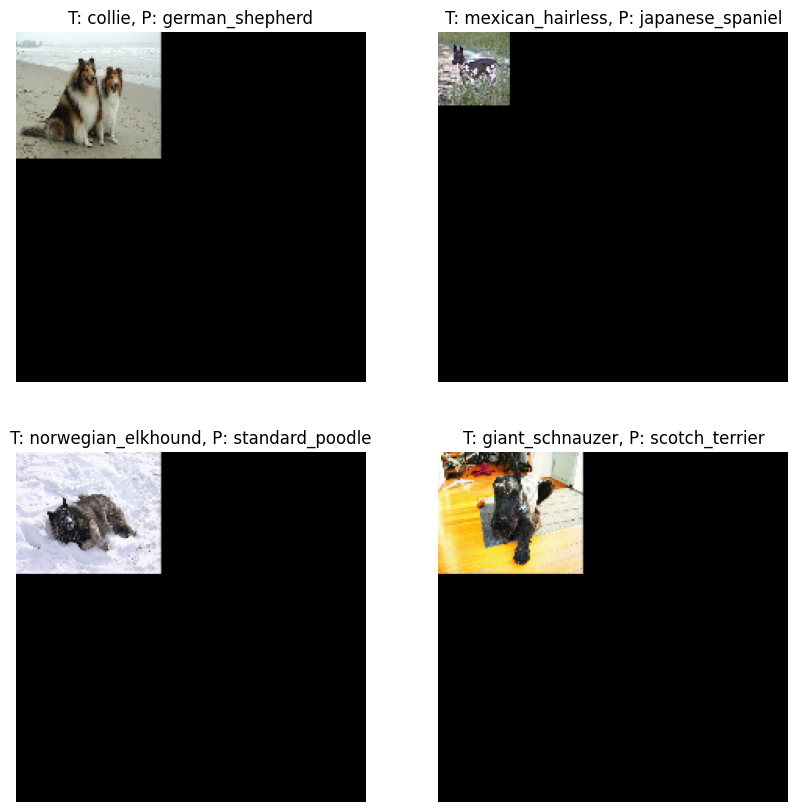

In [23]:
# Mostrem algunes imatges per veure si les prediccions han estat encertades.
plt.figure(figsize=(10, 10))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(imatges[i].numpy().astype("uint8"))
    original = class_names[true_labels[i]].split("-")[1]
    predicted = class_names[predicted_labels[i]].split("-")[1]
    plt.title(f"T: {original}, P: {predicted}")
    plt.axis("off")
plt.show()

## Conclusió

Amb la finalitat de fer l'activitat, sense fer servir el dataset proposat per la tutora. He agafat un dataset on les imatges no tenen la mateixa mida ni qualitat, on els gososos estan en diferens posicions i rodejats d'altres objectes.

He hagut de suar per poder-ho integrar, però al final ha funcionat, com a resultat tenim un model que encerta menos que un cec, per la mala qualitat del dataset o de la preparació d'aquest. Hauría d'haber retallat la imatge amb el ROI de la imatge sense el flag as_supervised.

Potser llavorens la qualitat hagués millorat, l'objectiu d'apendre a agafar un model ja existent, congelar les capes d'entrada i aplicar una capa de sortidar per entrenar-ho amb un dataset personalitzat a sigut una experiencia molt útil.